In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import GridSearchCV
import scipy.stats
import eli5

In [30]:
data = pd.read_csv("ground_truth4ML.csv",names=["row_num", "word", "tag"],sep='\t',encoding='utf8' , quotechar = '"')

In [31]:
data = data.fillna("O")
data = data.iloc[1:]

In [32]:
data.head()

,row_num,word,tag
1,665976,(,O
2,665977,10600,O
3,665978,Fuss,O
4,665979,=,O
5,665980,3350,O


In [33]:
class State:
    def __init__(self):
        self.b = 1.0
 
    def increase(self):
        self.b = self.b + 1
        return self.b
    
state = State()

In [34]:
data["sentence"] = data.word.apply(lambda x: state.increase() if x in ['.'] else state.b)
data.head(50)

,row_num,word,tag,sentence
1,665976,(,O,1.0
2,665977,10600,O,1.0
3,665978,Fuss,O,1.0
4,665979,=,O,1.0
5,665980,3350,O,1.0
6,665981,Meter,O,1.0
7,665982,Keil,O,1.0
8,665983,.,O,2.0
9,665984,),O,2.0
10,665985,Sonntag,O,2.0


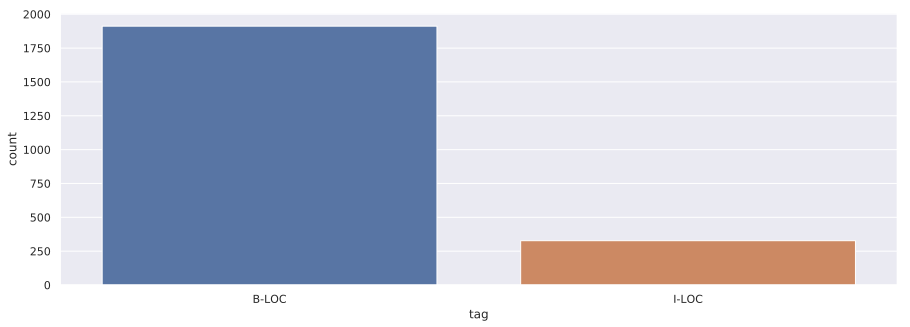

In [8]:
plt.figure(figsize=(15,5))
ax = sns.countplot('tag', data = data.loc[data['tag'] != 'O'])
plt.show()

In [35]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [36]:
getter = SentenceGetter(data)
sentences = getter.sentences
print(sentences[5])

[(u'.', 'O'), (u'Besonders', 'O'), (u'dankend', 'O'), (u'gedenke', 'O'), (u'ich', 'O'), (u'zweier', 'O'), (u'schwerer', 'O'), (u'wollener', 'O'), (u'Decken', 'O'), (u',', 'O'), (u'welche', 'O'), (u'als', 'O'), (u'Eigenthum', 'O'), (u'der', 'O'), (u'H\xfctte', 'O'), (u'uns', 'O'), (u'zu', 'O'), (u'Gute', 'O'), (u'kamen', 'O'), (u';', 'O'), (u'ich', 'O'), (u'kann', 'O'), (u'hier', 'O'), (u'nur', 'O'), (u'den', 'O'), (u'Wunsch', 'O'), (u'aussprechen', 'O'), (u',', 'O'), (u'unser', 'O'), (u'Alpenverein', 'O'), (u'm\xf6ge', 'O'), (u'f\xfcr', 'O'), (u'noch', 'O'), (u'einige', 'O'), (u'solche', 'O'), (u'Exemplare', 'O'), (u'sorgen', 'O'), (u',', 'O'), (u'da', 'O'), (u'die', 'O'), (u'Johann\u2019sh\xfctte', u'B-LOC'), (u'auch', 'O'), (u'in', 'O'), (u'neuerer', 'O'), (u'Zeit', 'O'), (u'stark', 'O'), (u'frequentirt', 'O'), (u'wird', 'O'), (u'(', 'O'), (u'es', 'O'), (u'waren', 'O'), (u'gleich', 'O'), (u'Tages', 'O'), (u'darauf', 'O'), (u'nicht', 'O'), (u'weniger', 'O'), (u'als', 'O'), (u'f\xfcnf'

In [37]:
# find the number of words in the dataset
words = list(set(data["word"].values))
n_words = len(words)
print(n_words)

9464


In [31]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

('Maximum sequence length:', 210)


In [1]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

NameError: name 'plt' is not defined

In [38]:
def word2features(sent, i):
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit()
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper()
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper()
        })
    else:
        features['EOS'] = True

    return features


In [12]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]



In [13]:
#Creating the train and test set
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]


['O', 'O', 'O', 'O', 'O', 'O', 'O']

In [14]:
#Creating the CRF model
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [15]:

pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [16]:
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

              precision    recall  f1-score   support

       B-LOC       0.88      0.63      0.74      1912
       I-LOC       0.80      0.73      0.77       327
           O       0.98      1.00      0.99     40858

   micro avg       0.98      0.98      0.98     43097
   macro avg       0.89      0.79      0.83     43097
weighted avg       0.98      0.98      0.98     43097




Compared to the Random Forest classifier, the CRF classifier did better as the scores have improved. However, the precision and recall metrics of the classes individually have not improved. Maybe the model is again remembering words and not taking into the context information completely. We will try tuning the model manually to see if we can improve it.

In [21]:
#Tuning the parameters manually, setting c1 = 10
crf2 = CRF(algorithm='lbfgs',
          c1=5,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [22]:
pred = cross_val_predict(estimator=crf2, X=X, y=y, cv=5)
report = flat_classification_report(y_pred=pred, y_true=y)
print(report)

              precision    recall  f1-score   support

       B-LOC       0.87      0.47      0.61      1912
       I-LOC       0.78      0.67      0.72       327
           O       0.97      1.00      0.98     40858

   micro avg       0.97      0.97      0.97     43097
   macro avg       0.87      0.71      0.77     43097
weighted avg       0.97      0.97      0.97     43097



In [23]:
crf2.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=False, averaging=None, c=None, c1=5, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

**
Hyperparameter tuning using Randomized CV Search¶
**

In [24]:
#First we select all the tags that are relevant for us i.e. remove the 'O' tag from the list. 
labels = list(crf2.classes_)
labels = list(filter(lambda a: a != 'O', labels))
print(labels)

['B-LOC', 'I-LOC']


In [25]:
%%time
#Now we will create the Randomized CV search model wherein we will use a modified F1 scorer model considering only the relevant labels
# define fixed parameters and parameters to search
crf3 = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=False
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.2min finished


CPU times: user 5min 53s, sys: 3.41 s, total: 5min 56s
Wall time: 6min 13s


In [26]:
crf3 = rs.best_estimator_
y_pred = crf3.predict(X)
print(metrics.flat_classification_report(
    y, y_pred, labels=labels, digits=3))

              precision    recall  f1-score   support

       B-LOC      0.998     0.999     0.999      1912
       I-LOC      1.000     1.000     1.000       327

   micro avg      0.999     0.999     0.999      2239
   macro avg      0.999     0.999     0.999      2239
weighted avg      0.999     0.999     0.999      2239



In [28]:
crf3.fit(X,y)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=False, averaging=None, c=None,
  c1=0.0498669283449194, c2=0.02782452890438138,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [29]:
eli5.show_weights(crf3, top=30)

AttributeError: 'NoneType' object has no attribute 'group'